In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import xarray as xr
import torch.nn.functional as F
import torch
import torch.nn as nn
import random
import seaborn as sns

torch.manual_seed(1)
random.seed(0)
np.random.seed(0)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda


In [2]:
train_bmra = pd.read_csv("train BMRA.csv")
train_bmra['Date'] = pd.to_datetime(train_bmra['Date'])

In [3]:
train_bmra

,Date,Open,High,Low,Close,Adjusted Close,Volume
0,1984-07-09,5.50,5.50,5.25,5.25,5.25,7900
1,1984-10-09,5.25,5.50,5.25,5.25,5.25,600
2,1984-11-09,5.25,5.50,5.25,5.25,5.25,3500
3,1984-12-09,5.50,5.50,5.50,5.50,5.50,700
4,1984-09-13,5.50,5.50,5.00,5.00,5.00,1700
...,...,...,...,...,...,...,...
9692,2023-02-22,2.86,2.93,2.84,2.84,2.84,21800
9693,2023-02-23,2.86,2.91,2.71,2.71,2.71,29400
9694,2023-02-24,2.67,2.77,2.62,2.68,2.68,20700
9695,2023-02-27,2.65,2.73,2.65,2.67,2.67,14200


In [4]:
train_amzn = pd.read_csv('train AMZN.csv')
train_amzn['Date'] = pd.to_datetime(train_amzn['Date'])

### 1. Skenario pertama, hanya menggunakan 1 variabel saja yaitu column "close"

In [5]:
len_seq = 12
batch_size = 16

In [6]:
def totensor(arr):
    ts = torch.from_numpy(np.float32(arr))
    return ts

In [7]:
#fungsi many to one untuk membuat data time series menjadi data input dan data target
def many_to_one(raw_series,len_seq): # len_seq adalah panjang sequence, len_target adalah panjang target  
    data = []
    target = []
    for i in range(len(raw_series)-len_seq):
        data.append(raw_series[i:len_seq+i])
        target.append(raw_series[len_seq+i])
        
    assert len(data) == len(target), "Panjang data input harus sesuai dengan target"
    return np.array(data),np.array(target)

In [8]:
col_picked = ['Date','Close']
train_amzn = train_amzn[col_picked]
train_bmra = train_bmra[col_picked] 

val_bmra = train_bmra['Close'].values
val_amzn = train_amzn['Close'].values

### Visualisasi timeseries data BMRA dan Amazon

In [9]:
def plot_series(data,x_column,y_column,title,x_label,y_label):
    sns.set_style("white")
    cm = plt.get_cmap('rainbow')
    fig = plt.figure()
    ax = fig.add_axes([0,0,2,1.4])
    sns.lineplot(x = x_column, y = y_column, data = data ,linewidth=3, color=cm(1/8), label= y_column)
    ax.tick_params(labelsize=20)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.legend(loc = 2, fontsize = 13)
    ax.set_title(title, fontsize = 28)
    ax.set_ylabel(y_label,fontsize = 22)
    ax.set_xlabel(x_label,fontsize = 22)
    ax.grid(linestyle='dashdot', color='k', alpha=0.3)
    plt.show()

##### Amazon

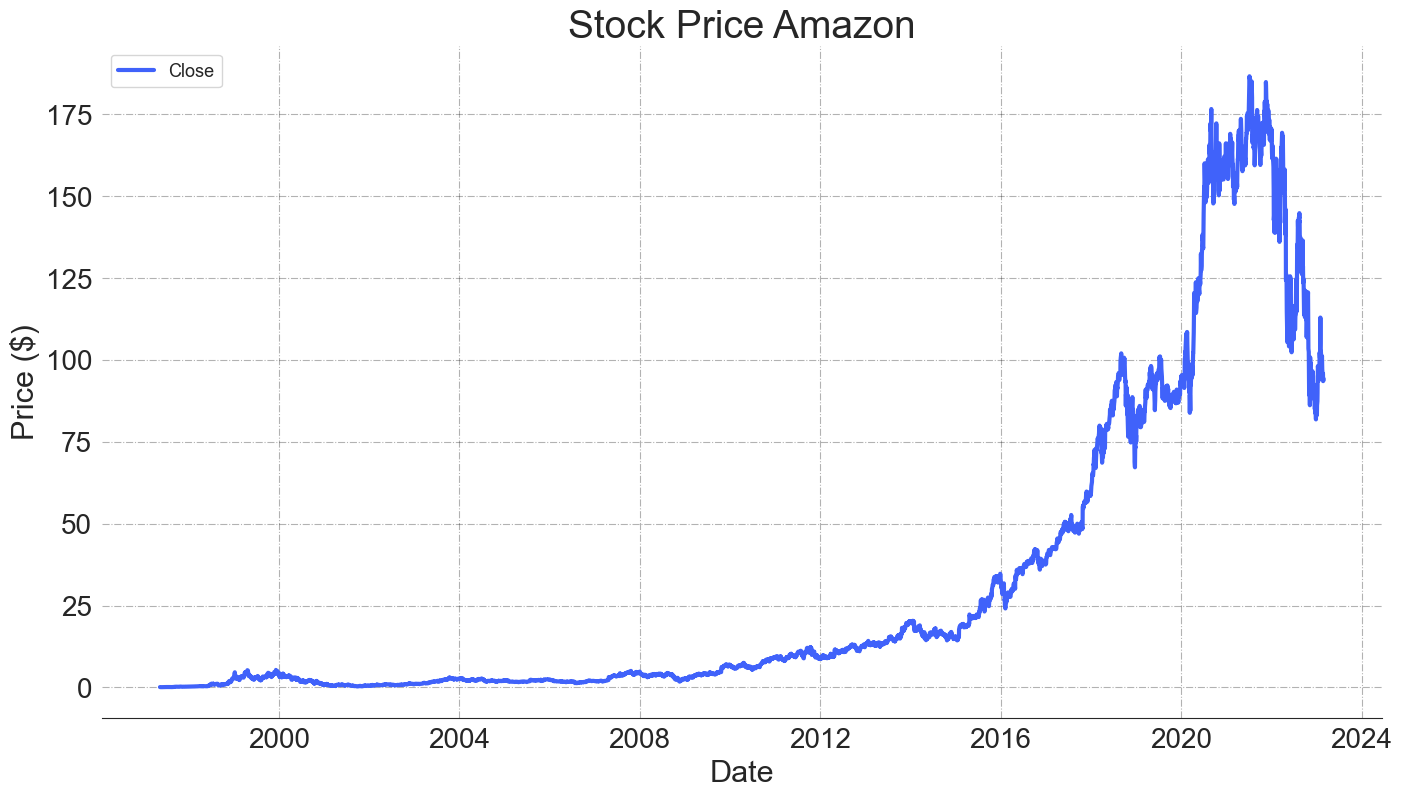

In [10]:
plot_series(train_amzn,'Date', 'Close',"Stock Price Amazon","Date" , "Price ($)")

##### BMRA

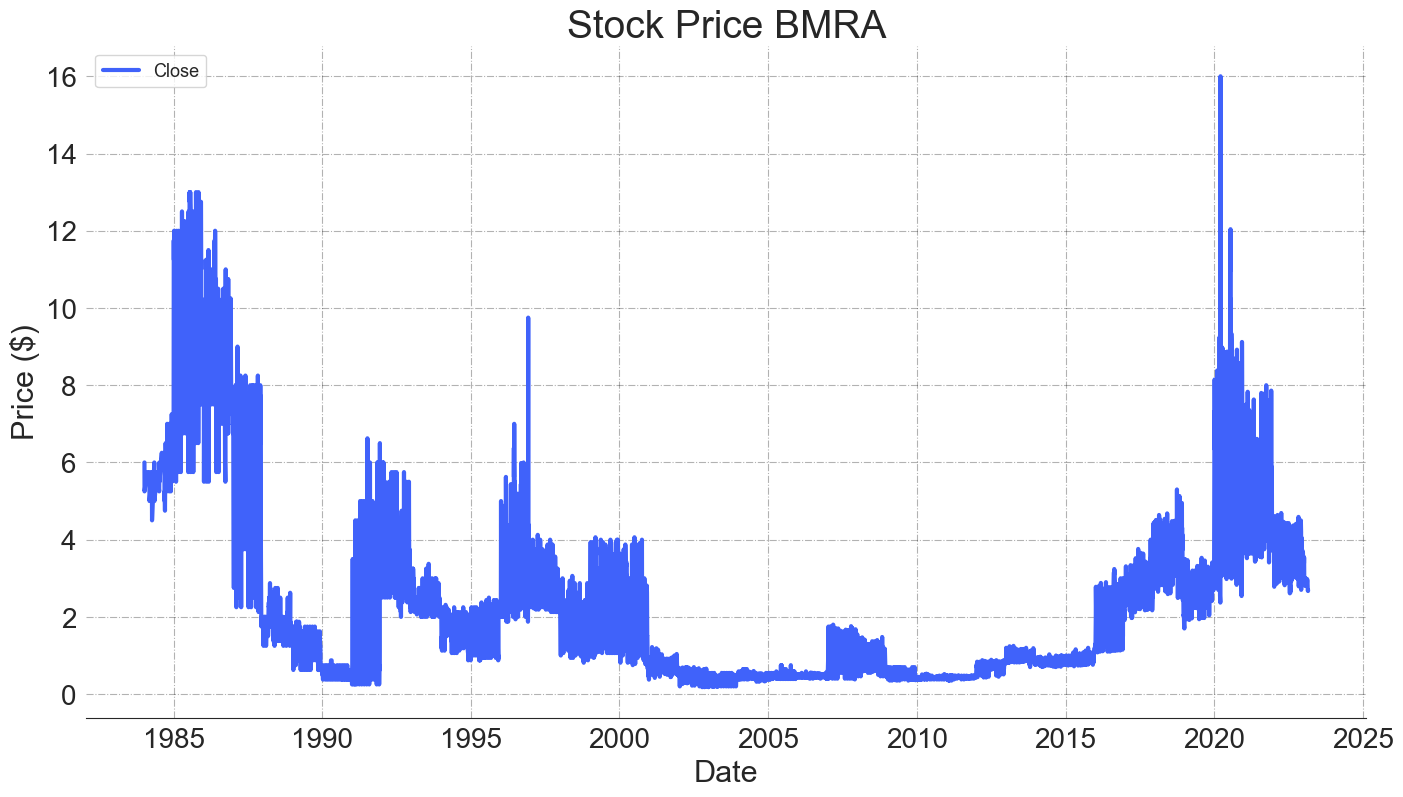

In [11]:
plot_series(train_bmra,'Date', 'Close',"Stock Price BMRA","Date" , "Price ($)")

#### Normalisasi data menggunakan MinMaxScaler

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler_bmra = MinMaxScaler(feature_range = (-1,1))
scaler_amzn = MinMaxScaler(feature_range = (-1,1))

scaled_val_bmra = scaler_bmra.fit_transform(val_bmra.reshape(-1,1))
scaled_val_amzn = scaler_amzn.fit_transform(val_amzn.reshape(-1,1))

In [13]:
X_bmra, y_bmra = many_to_one(scaled_val_bmra,len_seq)
X_amzn, y_amzn = many_to_one(scaled_val_amzn,len_seq)

In [14]:
X_bmra.shape, y_bmra.shape

((9685, 12, 1), (9685, 1))

In [18]:
X_amzn.shape, y_amzn.shape

((6478, 12, 1), (6478, 1))

In [19]:
Xgabungan = np.concatenate([X_bmra,X_amzn], axis = 0)
ygabungan = np.concatenate([y_bmra,y_amzn], axis = 0)

In [20]:
print(Xgabungan.shape, ygabungan.shape)

(16163, 12, 1) (16163, 1)


In [21]:
#split index untuk membedakan data validasi dan data training
split_index = int(len(Xgabungan) * 1)

In [22]:
X_train, X_val, y_train, y_val = train_test_split(Xgabungan, ygabungan, test_size=0.002, random_state=42)

X_test_bmra = scaled_val_bmra[-len_seq:]
X_test_amzn = scaled_val_amzn[-len_seq:]

X_train.shape, X_val.shape, y_train.shape, y_val.shape, X_test_bmra.shape, X_test_amzn.shape

((16130, 12, 1), (33, 12, 1), (16130, 1), (33, 1), (12, 1), (12, 1))

In [23]:
X_train,X_val,y_train,y_test = totensor(X_train),totensor(X_val),totensor(y_train),y_val

In [24]:
print(f"Ukuran X_train: {X_train.shape}, ukuran y_train: {y_train.shape}")
print(f"Ukuran X_test: {X_val.shape}, ukuran y_test: {y_val.shape}")

Ukuran X_train: torch.Size([16130, 12, 1]), ukuran y_train: torch.Size([16130, 1])
Ukuran X_test: torch.Size([33, 12, 1]), ukuran y_test: (33, 1)


In [25]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
val_dataset = TimeSeriesDataset(X_val, y_val)

In [26]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [27]:
#Melakukan pengecekan informasi shape data setiap batch nya
for n, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    if n == 3:
        break

torch.Size([16, 12, 1]) torch.Size([16, 1])
torch.Size([16, 12, 1]) torch.Size([16, 1])
torch.Size([16, 12, 1]) torch.Size([16, 1])
torch.Size([16, 12, 1]) torch.Size([16, 1])


#### Create Model

In [28]:
class LSTM(nn.Module):
    def __init__(self,input_size,hidden_size, num_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size,hidden_size,num_layers, batch_first = True)
        self.fc1 = nn.Linear(hidden_size,32)
        self.fc2 = nn.Linear(32,8)
        self.fc3 = nn.Linear(8,1)
        
    def forward(self, x):
        h,_ = self.lstm(x)
        y1 = self.fc1(h[:,-1,:])
        y2 = self.fc2(y1)
        yhat = self.fc3(y2)
        return yhat
    
class RNN(nn.Module):
    def __init__(self,input_size,hidden_size, num_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.num_layers = num_layers
        self.RNN = nn.RNN(input_size,hidden_size,num_layers, batch_first = True)
        self.fc1 = nn.Linear(hidden_size,1)
        
    def forward(self, x):
        h,_ = self.RNN(x)
        y1 = self.fc1(h[:,-1,:])
        return y1
    
class SimpleGRU(nn.Module):    
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super().__init__()
        
        self.gru = nn.GRU(
            input_size, 
            hidden_size, 
            num_layers=num_layers,
            batch_first=True
        )
        
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h, _ = self.gru(x)
        y = self.fc(h)
        
        return y
    
class GRU(nn.Module):
    def __init__(self,input_size,hidden_size, num_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size,hidden_size,num_layers, batch_first = True)
        self.fc1 = nn.Linear(hidden_size,32)
        self.fc2 = nn.Linear(32,10)
        self.fc3 = nn.Linear(10,1)
        
    def forward(self, x):
        h,_ = self.gru(x)
        y = self.fc1(h[:,-1,:])
        y = self.fc2(y)
        y = self.fc3(y)
        return y

#### Define Model

In [29]:
from torch.optim import Adam, LBFGS, SGD
input_size = 1
hidden_size = 10
num_layers = 1
model = GRU(input_size, hidden_size, num_layers)
#model = LSTM(input_size, hidden_size, num_layers)

learning_rate = 0.001
num_epochs = 16
criterion = nn.MSELoss()

#### Train Model

###### With Optimizer Adam

In [30]:
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [31]:
def train(model,train_loader,criterion, optimizer, epochs, device):
    model.train()
    error_track = {}
    for epoch in range(epochs):
        for idx_batch,batch in enumerate(train_loader):
            x_batch, y_batch  = batch[0].to(device), batch[1].to(device)
            #forward pass
            output = model(x_batch)
            loss = criterion(output,y_batch)
            
            #backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        error_track[f"Epoch {epoch+1}"] = loss.item()
        print(f"Epoch {epoch+1} with loss {loss.item()}")
    return model,error_track

In [34]:
model.to(device)

GRU(
  (gru): GRU(1, 10, batch_first=True)
  (fc1): Linear(in_features=10, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=1, bias=True)
)

In [35]:
model,error = train(model,train_loader,criterion, optimizer, num_epochs, device)

Epoch 1 with loss 0.0003180725616402924
Epoch 2 with loss 4.6938143896113615e-06
Epoch 3 with loss 0.00012963349581696093
Epoch 4 with loss 3.2958578231045976e-05
Epoch 5 with loss 4.97842556796968e-05
Epoch 6 with loss 0.00021985462808515877
Epoch 7 with loss 0.0007299828575924039
Epoch 8 with loss 0.0013390843523666263
Epoch 9 with loss 6.833455699961632e-05
Epoch 10 with loss 0.0008540514972992241
Epoch 11 with loss 1.222798709932249e-05
Epoch 12 with loss 6.224462413229048e-05
Epoch 13 with loss 0.00013556878548115492
Epoch 14 with loss 2.325696186744608e-05
Epoch 15 with loss 1.9912688458134653e-06
Epoch 16 with loss 5.201055319048464e-05


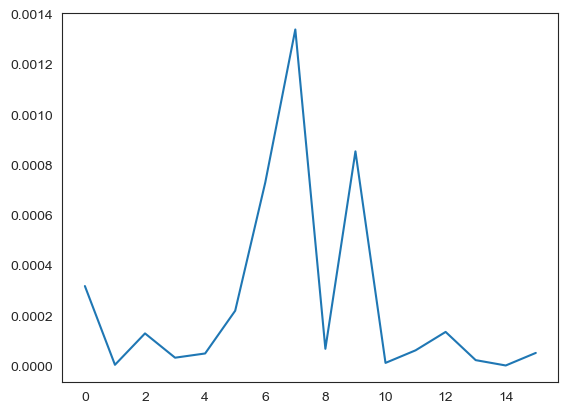

In [36]:
plt.plot(list(error.values()))

In [43]:
X_val = X_val.to(device)
with torch.no_grad():
    test_predictions = model(X_val)
    #test_predictions = test_predictions.detach().numpy()

for n, pred in enumerate(test_predictions):
    print(pred,y_val[n])
    if n == 5:
        break

tensor([-0.4783], device='cuda:0') [-0.45385588]
tensor([-0.9831], device='cuda:0') [-0.98124717]
tensor([-0.5933], device='cuda:0') [-0.5935221]
tensor([-0.6491], device='cuda:0') [-0.70670038]
tensor([-0.9192], device='cuda:0') [-0.91782554]
tensor([-0.9785], device='cuda:0') [-0.97681287]


In [44]:
predicted_val = scaler_amzn.inverse_transform(test_predictions)

target_val = scaler_amzn.inverse_transform(y_val)
predicted_val.shape, target_val.shape

predicted_val = predicted_val.flatten()
target_val = target_val.flatten()

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [39]:
from math import sqrt
def MAE(pred,target):
    assert len(pred) == len(target), "Panjang data prediksi dan Ground Truth harus sama"
    
    error = []
    for i in range (len(pred)):
        error.append(abs(pred[i] - target[i]))
    out = sum(error)/ len(error)
    return out

def RMSE(pred,target):
    assert len(pred) == len(target), "Panjang data prediksi dan Ground Truth? harus sama"
    error = []
    for i in range (len(pred)):
        error.append((pred[i] - target[i])**2)
    mse = sum(error)/ len(error)
    return sqrt(mse)

In [137]:
#Calculate error
mae = MAE(target_val, predicted_val)
print("MAE: ", mae)
rmse = RMSE(target_val, predicted_val)
print("RMSE: ", rmse)

MAE:  1.7010669251840045
RMSE:  2.4087973452488978


#### Test Data

In [138]:
test_amzn = pd.read_csv('test AMZN.csv')
test_bmra = pd.read_csv('test BMRA.csv')

test_val_amzn = test_amzn['Close'].values
test_val_bmra = test_bmra['Close'].values

X_test_bmra = X_test_bmra.reshape((1,len_seq, 1))
X_test_amzn = X_test_amzn.reshape((1,len_seq, 1))

X_test_bmra = totensor(X_test_bmra)
X_test_amzn = totensor(X_test_amzn)

In [139]:
def predict_future(model,X_test,len_seq,len_future):
    x = X_test
    for i in range(len_future):
        yhat = model(x[-len_seq:])
        x = torch.cat((x, yhat.unsqueeze(1)), dim=1)
    out = x[0,-len_future:,:]
    return out

In [140]:
with torch.no_grad():    
    yhat_future_bmra = predict_future(model,X_test_bmra,len_seq,len(test_val_bmra))
    yhat_future_amzn = predict_future(model,X_test_amzn,len_seq,len(test_val_amzn))

future_bmra = yhat_future_bmra.detach().numpy()
future_bmra = scaler_bmra.inverse_transform(future_bmra.reshape(len(test_val_bmra),1))
future_bmra = future_bmra.flatten()

future_amzn = yhat_future_amzn.detach().numpy()
future_amzn = scaler_amzn.inverse_transform(future_amzn.reshape(len(test_val_amzn),1))
future_amzn = future_amzn.flatten()

In [141]:
#Calculate Error
print("RMSE BMRA: " ,RMSE(test_val_bmra,future_bmra))
print("RMSE AMZN: " ,RMSE(test_val_amzn,future_amzn))

print("MAE BMRA: " ,MAE(test_val_bmra,future_bmra))
print("MAE AMZN: " ,MAE(test_val_amzn,future_amzn))

RMSE BMRA:  1.7843907186629033
RMSE AMZN:  20.609841350012207
MAE BMRA:  1.577232187344478
MAE AMZN:  18.643506588885963


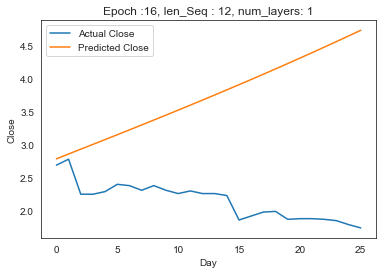

In [142]:
plt.plot(test_val_bmra, label='Actual Close')
plt.plot(future_bmra, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.title(f"Epoch :{num_epochs}, len_Seq : {len_seq}, num_layers: {num_layers}")
plt.show()

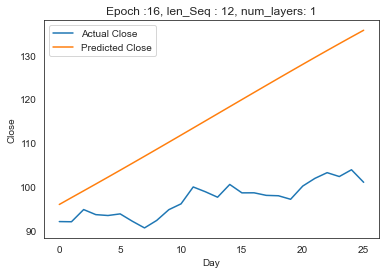

In [143]:
plt.plot(test_val_amzn, label='Actual Close')
plt.plot(future_amzn, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.title(f"Epoch :{num_epochs}, len_Seq : {len_seq}, num_layers: {num_layers}")
plt.show()

In [ ]:
# Load the saved model
model = LSTM(input_size, hidden_size, num_layers)
model.load_state_dict(torch.load('my_model.pt'))